# Fallback - Event Propensity Scoring
* StellarAlgo Data Science
* Ryan Kazmerik
* Oct 06, 2022

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

from pycaret.classification import *
from shared_utilities import helpers

In [28]:
CLUSTER = "prod-app"
DATABASE = "stlrcfl"
LKUPCLIENTID = "35"

In [29]:
df_event_propensity_training = helpers.get_event_propensity_training_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    start_year=2010,
    end_year=2021
)

df_event_propensity_training.shape

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


(16918, 17)

In [30]:
df_event_propensity_training.head()

,daysout,mindaysout,maxdaysout,dimcustomermasterid,recent_openrate,recent_clickrate,eventdate,eventname,inmarket,distancetovenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventday,frequency_eventtime,count_merchowned
0,4 to 7 Days Out,4,8.0,326205612,0.0,0.0,2018-06-16,180616 - Hamilton Tiger-Cats,True,6.34,329,0,7,0.0,0.0,0.0,0
1,Over a Week,8,NaN,326205612,0.0,0.0,2018-07-21,180721 - Montreal Alouettes,True,6.34,364,0,9,0.0,0.0,0.0,0
2,4 to 7 Days Out,4,8.0,326205612,0.0,0.0,2018-08-04,180804 - BC Lions,True,6.34,378,0,10,0.0,0.0,0.0,0
3,Over a Week,8,NaN,326205612,0.0,0.0,2018-08-04,180804 - BC Lions,True,6.34,378,0,10,0.0,0.0,0.0,0
4,4 to 7 Days Out,4,8.0,326205612,0.0,0.0,2018-09-28,180928 - Toronto Argonauts,True,6.34,433,0,13,0.0,0.0,0.0,0


In [31]:
# choose the features for the stellar base retention model
features = [
    "daysout",
    "dimcustomermasterid",
    "did_purchase",
    "distancetovenue",
    "eventdate",
    "eventname",
    "events_purchased",
    "frequency_opponent",
    "frequency_eventday",
    "frequency_eventtime",
    "inmarket",
    "recent_openrate",
    "recent_clickrate",
    "tenure"
]

# copy your main dataframe
df_dataset = df_event_propensity_training

#creating the training and evaluation dataframe
df_dataset = df_dataset[features]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (14380, 14)
Unseen Data For Predictions: (2538, 14)



In [32]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimcustomermasterid",
        "eventdate",
        "eventname"
    ],
    silent=True,
    verbose=False,
    categorical_features=[
        "daysout"
    ],
    numeric_features=[
        "distancetovenue",
        "events_purchased",
        "frequency_opponent",
        "frequency_eventday",
        "frequency_eventtime",
        "inmarket",
        "recent_openrate",
        "recent_clickrate",
        "tenure"
    ]
);

In [33]:
model_matrix = compare_models(
    fold=10,
    include=["dt", "gbc", "lightgbm", "lr", "rf", "dummy"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8007,0.8871,0.7660,0.8259,0.7947,0.6016,0.6033,0.0290
gbc,Gradient Boosting Classifier,0.7470,0.8313,0.7261,0.7610,0.7430,0.4942,0.4948,0.2780
dt,Decision Tree Classifier,0.7409,0.7418,0.7163,0.7567,0.7358,0.4819,0.4829,0.7650
rf,Random Forest Classifier,0.7358,0.8136,0.7076,0.7532,0.7295,0.4718,0.4729,0.1780
lr,Logistic Regression,0.6738,0.7417,0.6466,0.6874,0.6662,0.3478,0.3486,0.0560
dummy,Dummy Classifier,0.5036,0.5000,1.0000,0.5036,0.6699,0.0000,0.0000,0.0050


In [34]:
best_model = create_model(model_matrix);
final_model = finalize_model(best_model);

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8103,0.8925,0.7744,0.8368,0.8044,0.6208,0.6226
1,0.7997,0.8934,0.7565,0.8307,0.7918,0.5996,0.6020
2,0.7905,0.8789,0.7691,0.8058,0.7870,0.5811,0.5817
3,0.7807,0.8705,0.7431,0.8060,0.7733,0.5616,0.5633
4,0.8061,0.8863,0.7496,0.8474,0.7955,0.6124,0.6166
5,0.8020,0.8918,0.7756,0.8210,0.7977,0.6041,0.6050
6,0.8052,0.8945,0.7789,0.8244,0.8010,0.6106,0.6115
7,0.8241,0.9039,0.7825,0.8561,0.8176,0.6483,0.6508
8,0.8028,0.8852,0.7646,0.8307,0.7963,0.6058,0.6078


In [45]:
df_gamedays = helpers.get_event_propensity_gamedays(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID
)

df_gamedays.head()

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


,game_date
0,2022-10-14
1,2022-10-29
2,2023-06-01


In [57]:
predictions =[]
for date in df_gamedays["game_date"]:
    
    df_inference = helpers.get_event_propensity_scoring_dataset(
        cluster=CLUSTER,
        database=DATABASE,
        lkupclientid=LKUPCLIENTID,
        game_date=date
    )

    df_scores = predict_model(final_model, data=df_inference, raw_score=True)
    predictions.append(df_scores)

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com
Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com
Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


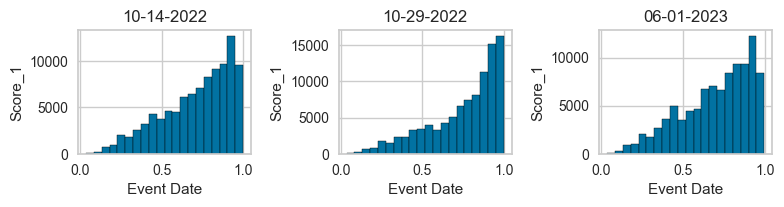

In [51]:
for idx, df_game in enumerate(predictions):
    
    plt.subplot(3, 3, idx+1)
    
    event_date = df_game['eventdate'].unique()[0].strftime("%m-%d-%Y")
    
    plt.title(event_date, fontsize = 12)
    plt.xlabel("Event Date")
    plt.ylabel("Score_1")
    plt.hist(df_game['Score_1'], bins= 20, edgecolor = "black")
    
plt.tight_layout()
plt.show()

In [53]:
for df_game in predictions:

    event_date = df_game['eventdate'].unique()[0].strftime("%m-%d-%Y")
    df_game.to_csv(f"data/scores_{event_date}.csv", index=False)